# Edge Detection of Image

## Edge detection

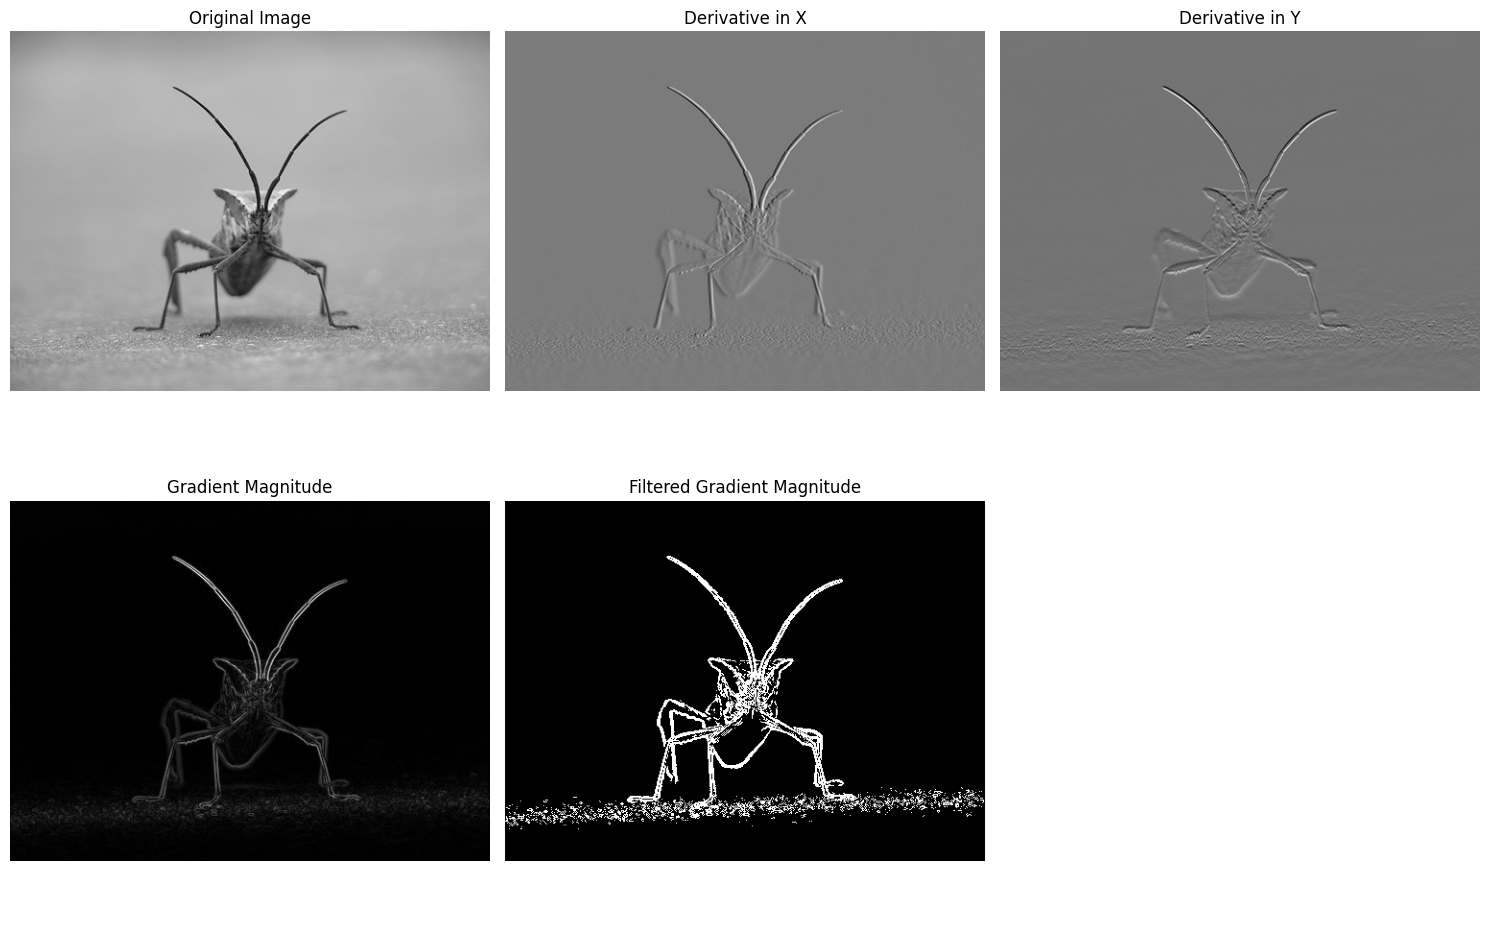

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the image and convert it to grayscale if it's not already
img = Image.open('image.png').convert('L')
img = np.asarray(img).astype(np.float32)

# Create a figure and axis object for subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Display original image
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

# Define delta x
deltaX = 1

# Calculate fx using numpy's gradient function
fx = np.zeros_like(img)
fx[:, 1:-1] = (img[:, 2:] - img[:, :-2]) / (2 * deltaX)

# Display the derivative in X
axs[0, 1].imshow(fx, cmap='gray')
axs[0, 1].set_title('Derivative in X')
axs[0, 1].axis('off')

# Calculate fy using numpy's gradient function
fy = np.zeros_like(img)
fy[1:-1, :] = (img[2:, :] - img[:-2, :]) / (2 * deltaX)

# Display the derivative in Y
axs[0, 2].imshow(fy, cmap='gray')
axs[0, 2].set_title('Derivative in Y')
axs[0, 2].axis('off')

# Calculate the magnitude of the gradient vectors
fgradabs = np.sqrt(fx**2 + fy**2)

# Normalize the gradient magnitude values to [0, 1]
fgradabs_normalized = fgradabs / np.max(fgradabs)

# Display the gradient magnitude
axs[1, 0].imshow(fgradabs_normalized, cmap='gray')
axs[1, 0].set_title('Gradient Magnitude')
axs[1, 0].axis('off')

# Filter out fgradabs_normalized values that are less than the threshold
threshold = 0.1
fgradabs_normalized_filtered = np.where(fgradabs_normalized > threshold, 1.0, 0.0)

# Display the filtered gradient magnitude
axs[1, 1].imshow(fgradabs_normalized_filtered, cmap='gray')
axs[1, 1].set_title('Filtered Gradient Magnitude')
axs[1, 1].axis('off')

# Hide the empty subplot
axs[1, 2].axis('off')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## Simple Diffusion

We are applying a simple diffusion model to reduce the noice in the image before performing the edge detection.

This is done with the following formula:

$$F(x,y,t+\Delta t) = F(x,y,t) + \Delta t \cdot \Delta F.$$

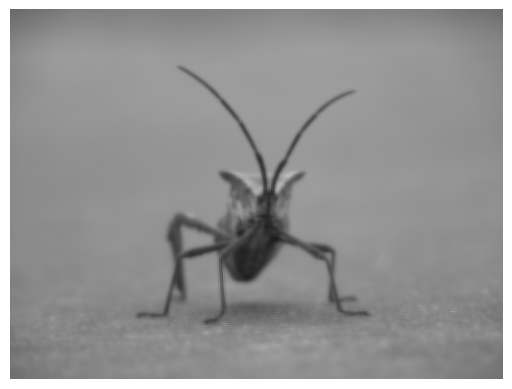

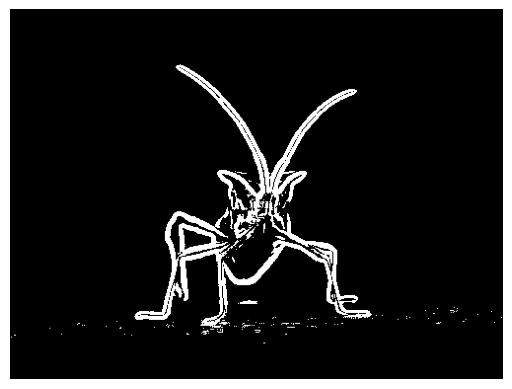

In [42]:
# Load the image
img = np.array(Image.open('image.png')).astype(np.float32)

# Define deltaX, iterations, and deltaT
deltaX = 1
iterations = 5
deltaT = 0.3

for _ in range(iterations):
    # Calculate f_y
    f_y = np.zeros_like(img)
    f_y[:, 1:-1] = (img[:, 2:] - img[:, :-2]) / (2 * deltaX)
    
    # Calculate f_x
    f_x = np.zeros_like(img)
    f_x[1:-1, :] = (img[2:, :] - img[:-2, :]) / (2 * deltaX)
    
    # Calculate f_xx
    f_xx = np.zeros_like(img)
    f_xx[1:-1, :] = (f_x[2:, :] - f_x[:-2, :]) / (2 * deltaX)
    
    # Calculate f_yy
    f_yy = np.zeros_like(img)
    f_yy[:, 1:-1] = (f_y[:, 2:] - f_y[:, :-2]) / (2 * deltaX)

    # Update the image using the heat equation
    img += deltaT * (f_xx + f_yy)

# Clip values to the valid range and convert to uint8
img = np.clip(img, 0, 255).astype(np.uint8)

# Display the resulting image
plt.imshow(img, cmap='gray')
plt.axis('off')  # Turn off axis
plt.show()

# Calculate the magnitude of the gradient vectors
fgradabs = np.sqrt(f_x**2 + f_y**2)

# Normalize the gradient magnitude values to [0, 1]
fgradabs_normalized = fgradabs / np.max(fgradabs)

# Filter out fgradabs_normalized values that are less than the threshold
threshold = 0.15
fgradabs_normalized_filtered = np.where(fgradabs_normalized > threshold, 1.0, 0.0)

# Display the filtered gradient magnitude
plt.imshow(fgradabs_normalized_filtered, cmap='gray')
plt.axis('off')  # Turn off axis
plt.show()

## Perona-Malik eqation for diffusion

Utilizing Perona-Malik equation to optimize the diffusion so it does not diffuse the "sharper" edges in the image.

$$ 
g(|| \nabla F||) = \frac{1}{\sqrt{1 + \frac{||\nabla F||^2}{\lambda ^2}}}
$$

Using this formula for $g$ we can diffuse the image with the following formula:

$$F(x,y,t+\Delta t) = F(x,y,t) + g \cdot \Delta t \cdot \Delta F.$$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


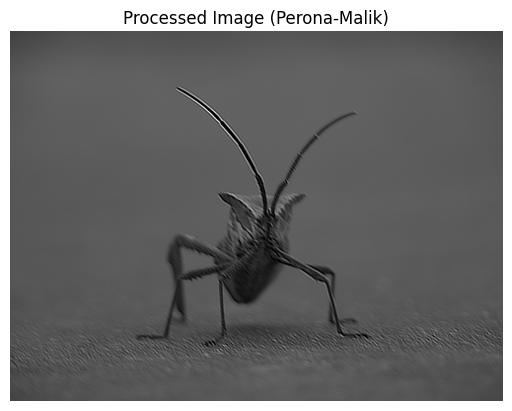

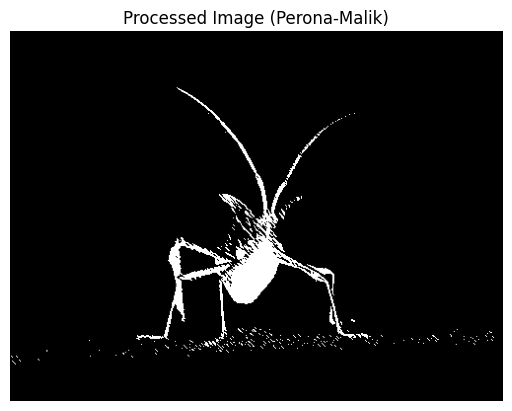

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the image and convert it to float32 and grayscale
img = np.array(Image.open('image.png')).astype(np.float32)

# Define parameters
deltaX = 1
iterations = 20
deltaT = 0.05
lam = 5000

# Initialize f_y and f_x
f_y = np.zeros_like(img)
f_x = np.zeros_like(img)

# Perona-Malik function
def g(x):
    return 1 / (np.sqrt(1 + ((x**2) / (lam**2))))

# Perform Perona-Malik diffusion
for i in range(iterations):
    # Calculate f_y
    f_y[:, 1:-1] = (img[:, 2:] - img[:, :-2]) / (2 * deltaX)
    
    # Calculate f_x
    f_x[1:-1, :] = (img[2:, :] - img[:-2, :]) / (2 * deltaX)
    
    # Magnitude of the gradient
    grad_magnitude = np.sqrt(f_x**2 + f_y**2)
    
    # Perona-Malik coefficient
    g_value = g(grad_magnitude)
    
    # Diffusion equation
    img[1:-1, 1:-1] += deltaT * (
        (g_value[1:-1, 1:-1] * (f_x[1:-1, 2:] - f_x[1:-1, :-2]) / (2 * deltaX)) +
        (g_value[1:-1, 1:-1] * (f_y[2:, 1:-1] - f_y[:-2, 1:-1]) / (2 * deltaX))
    )

# Normalize the image
img = img / np.max(img)

# Display the diffused image
plt.imshow(img, cmap='gray')
plt.title('Processed Image (Perona-Malik)')
plt.axis('off')  # Turn off axis
plt.show()

# Apply threshold
threshold = 0.2
img = np.where(img < threshold, 1.0, 0.0)

# Display the final image
plt.imshow(img, cmap='gray')
plt.title('Processed Image (Perona-Malik)')
plt.axis('off')  # Turn off axis
plt.show()